## Modelling and Visualisation 

In [ ]:
# Using convolutional neural networks, the following code aims to correctly classify male shoes into four
# categories; Formal, Sneakers, Boots and Slip-ons. The neural network will be constructed using the Python library 
# Keras with TensorFlow backend 

In [2]:
# Load libraries

import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import misc
import keras
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, Flatten, MaxPooling2D, Dropout
from keras.models import model_from_json
from keras.utils import np_utils
import keras.backend as k
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

%matplotlib inline

Using TensorFlow backend.


In [3]:
# Load data

X = np.load('X_Data.npy')
y = np.load('y_Data.npy')

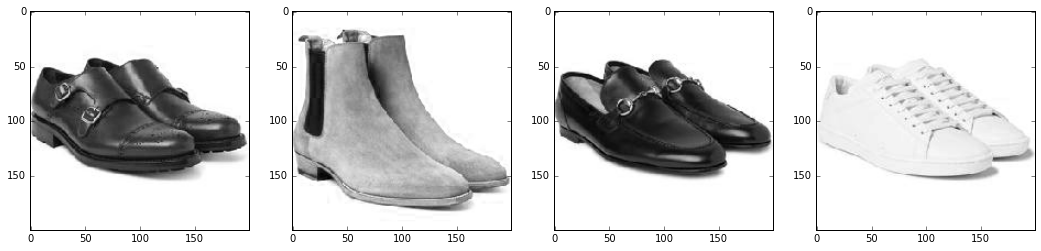

In [4]:
# Sample images

plt.figure(figsize = (18, 4))
plt.subplot(1, 4, 1)
plt.imshow(X[15,:,:,0], cmap='gray') # Formal
plt.subplot(1, 4, 2)
plt.imshow(X[2,:,:,0], cmap='gray') # Boots
plt.subplot(1, 4, 3)
plt.imshow(X[12,:,:,0], cmap='gray') # Slip-ons
plt.subplot(1, 4, 4)
plt.imshow(X[5,:,:,0], cmap='gray') # Sneakers
plt.show()

In [5]:
# Model architecture

model = Sequential() # Define sequential model

# The first convolutional layer takes the input image, which is 200 x 200 in size, and applies
# 32 different filters (each 3 X 3 matrices) in order to detect features in the shoes. The filters used are chosen,
# like the weights in the network, by backpropagation. Each filter is convolved over the input matrix to produce
# another image by means of matrix multiplication. An activation function is then applied element
# wise to the resulting image. The Relu activation function is defined as the max(0, x), in essence eliminating
# negative values.

model.add(Convolution2D(nb_filter = 32, nb_col = 3, nb_row = 3, input_shape = (200, 200, 3), activation = 'relu' ))

# MaxPooling is then applied to the convoluted image. The purpose of MaxPooling is to down sample the image, thus
# reducing the dimentionality of the feature space and allowing for assumptions to be made about features contained
# in the sub-regions binned. A 2 x 2 matrix convolves over the image matrix and takes the maximum value contained
# within that region. The advantaged of MaxPooling is that it prevents the network from over-fitting and also
# reduces the computational time in training.

model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout randomly selects 25% of the input units, setting them to zero. This also prevents over-fitting.

model.add(Dropout(0.25))

# Additional convolutional layers are added to pick out more granular features
model.add(Convolution2D(nb_filter = 32, nb_col = 3, nb_row = 3, activation = 'relu' ))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten, flattens the matrix into an array for input into the network.
model.add(Flatten())
# Hidden layers
# The initial weights of the nodes in the network are randomly assigned from the Uniform distribution, which are then
# updated in the backpropagation process.
model.add(Dense(128, init = 'uniform', activation = 'relu'))
model.add(Dense(128, init = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))

# Like in most networks, the final layer contains the activation function softmax. The softmax function squashes a
# K-dimentional vector z of arbitrary real values, to a K-dimentional vector of real values between 0 and 1 that
# sum to 1. The output of the softmax function will be the probability distribution over the different classes.
model.add(Dense(4, init = 'uniform', activation = 'softmax'))

# To evaluate the weights in the networks we must specify the loss function, and to optimise the weights we must
# specify the optimiser. Because this is a classification problem, the loss function used will be binary_crossentropy.
# The optimiser adam was chosen for no other reason than efficientsy. The evlauation metric used to judge
# the networks performance will be accuracy
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

![](model.png)

In [6]:
# Process data
 
#X = X.astype("float32")

# Convert target to categorical
Enc = LabelEncoder()
y = Enc.fit_transform(y)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X[:500,:,:,:], y[:500], test_size = 0.3, random_state = 42)

In [ ]:
# Fit model

model.fit(X_train, y_train, nb_epoch = 20, batch_size = 32, verbose = 5)

In [ ]:
# The above code was placed into a .py and the model fitted using an AWS EC2 instance. The instance chosen was 
# c4.4xlarge which features high performing processors and the lowest price/compute performance in EC2. The
# trained model was saved into two files; one Json file of the model architecture and the other a h5 file, which
# contained the optimised weights.

In [7]:
# Load files to create model

# Load Json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Load weights into model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [8]:
# Compile model
loaded_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

#### Model evaluation

In [9]:
# Load class list

class_list = np.load('Class_list.npy')

In [ ]:
# Evaluate model

train_score = loaded_model.evaluate(X_train, y_train)[1]
test_score = loaded_model.evaluate(X_test, y_test)[1]
print 'Training Accuracy: ', train_score
print 'Test Accuracy: ', train_score

In [ ]:
# Confusion matrix

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

In [ ]:
# Plot confusion matrix

cnf_matrix = confusion_matrix(y_test, loaded_model.predict_classes(y_test))
pct_matrix = ((cnf_matrix / sum(cnf_matrix).astype(np.float))*100).round()
plot_confusion_matrix(percentage, classes = class_list)

### Model visualisation

#### Filters

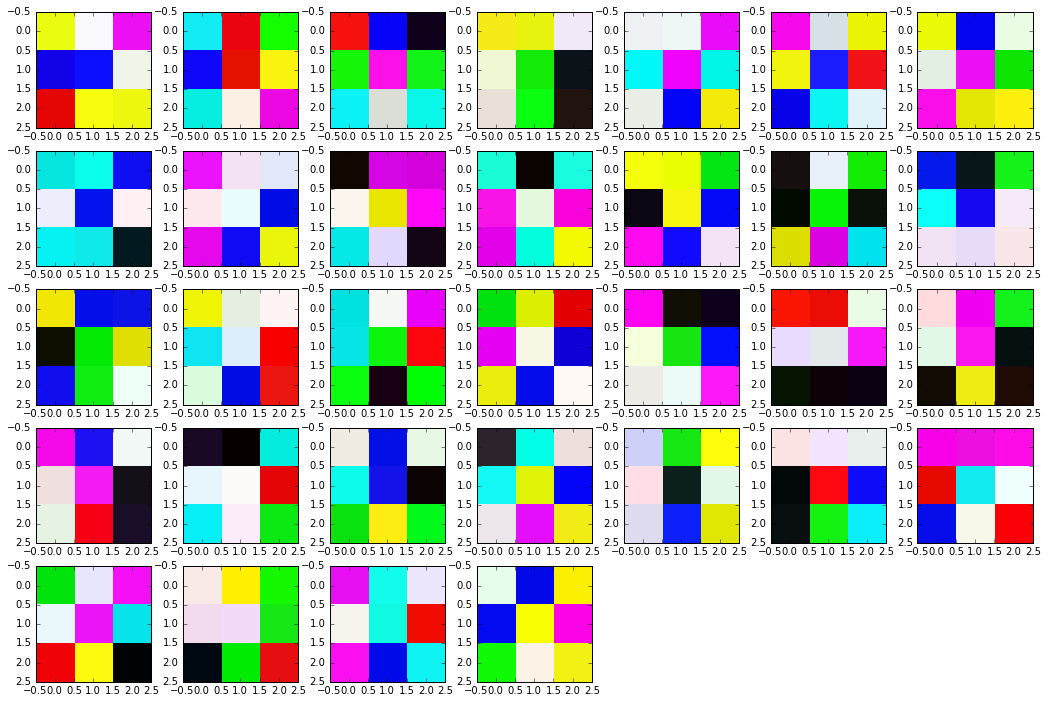

In [11]:
# Get filters from first convolutional layer
filters = loaded_model.layers[0].get_weights()[0]
filters = np.squeeze(filters) # reshape

# Plot filters
fig = plt.figure(figsize=(18, 12))
for x in range(0,32):
    fig.add_subplot(5, 7, x + 1)
    plt.imshow(filters[:,:,:,x], interpolation='nearest')
plt.show()

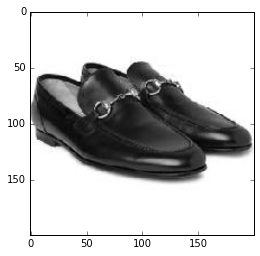

In [12]:
# Input image

plt.imshow(X[12,:,:,0], cmap = 'gray')
plt.show()

#### First convolutional layer

In [13]:
# Define convolution function using Tensorflow

convolution = k.function([loaded_model.layers[0].input], [loaded_model.layers[0].output])

In [14]:
# Apply convolution to image

convoluted_image = convolution([X[12,:,:,:].reshape(1, 200, 200, 3)])

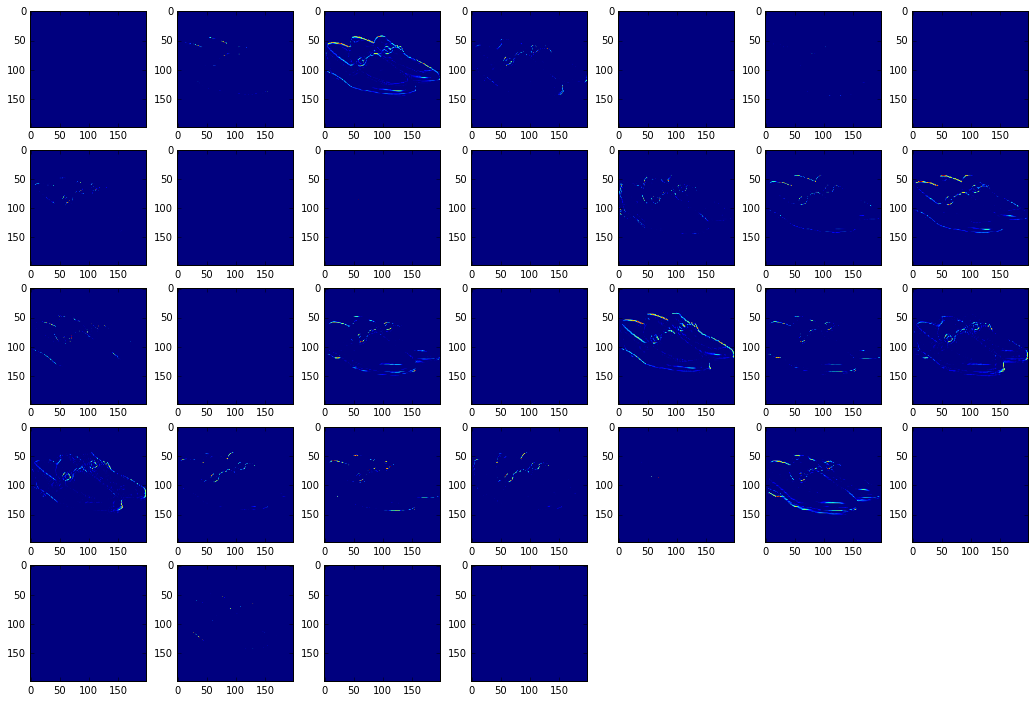

In [15]:
# Plot convoluted image for each filter

fig = plt.figure(figsize=(18, 12))
for x in range(1,33):
    temp_image = np.squeeze(convoluted_image[0][:,:,:,x-1])
    fig.add_subplot(5, 7, x)
    plt.imshow(temp_image)
plt.show()

#### Maxpooling

In [16]:
# Define Maxpooling function 

maxpooling = k.function([loaded_model.layers[1].input], [loaded_model.layers[1].output])

In [17]:
# Apply maxpooling to image

maxpool_image = maxpooling([convoluted_image[0]])

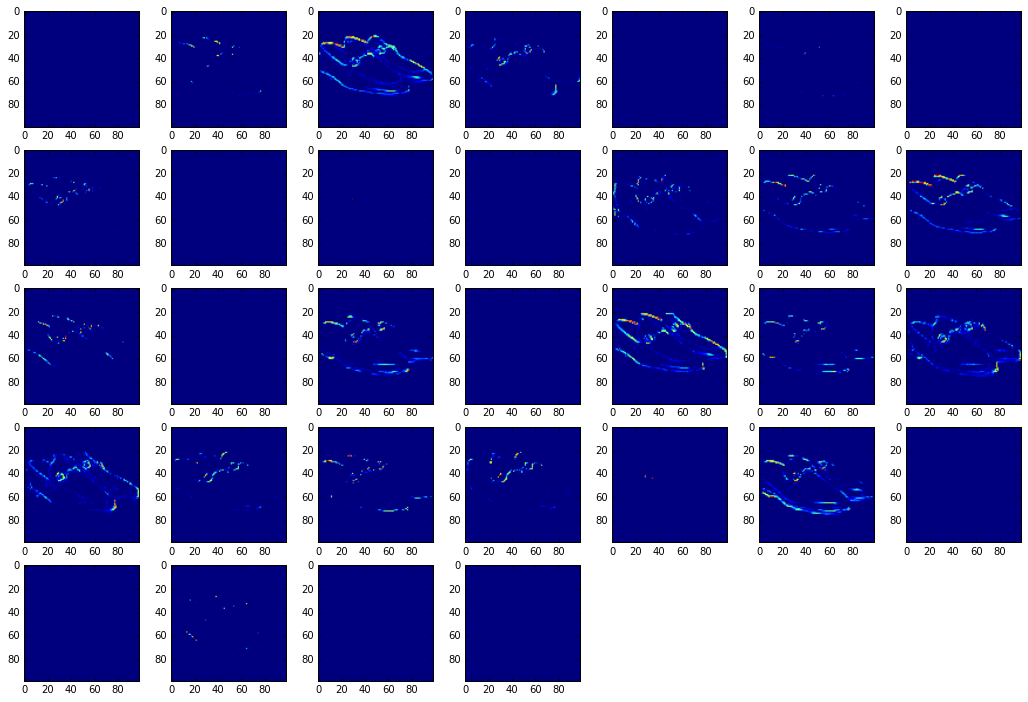

In [18]:
# Plot Maxpooled image (after convolution) for each filter

fig = plt.figure(figsize=(18, 12))
for x in range(1,33):
    temp_image = np.squeeze(maxpool_image[0][:,:,:,x-1])
    fig.add_subplot(5,7,x)
    plt.imshow(temp_image)
plt.show()

#### Second convolutional layer

In [19]:
# Define convolution function for second layer

convolution_2 = k.function([loaded_model.layers[3].input], [loaded_model.layers[3].output])

In [20]:
# Apply function to image

conv2_image = convolution_2([maxpool_image[0]])

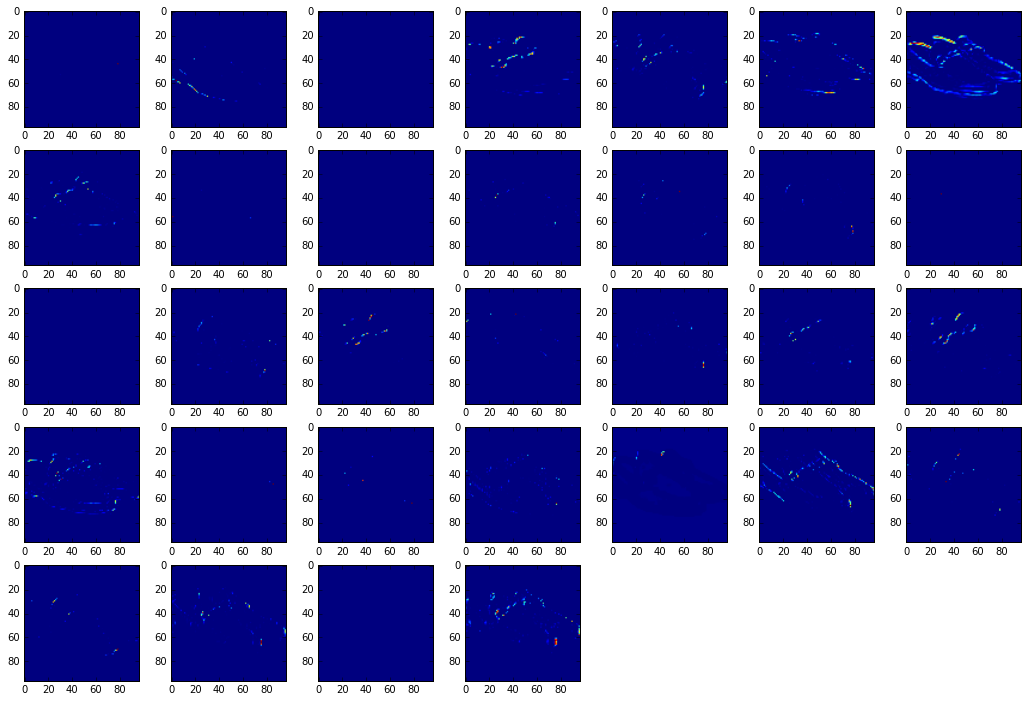

In [21]:
# Plot convoluted image (after first convolution and maxpooling) for each filter

fig = plt.figure(figsize=(18, 12))
for x in range(1,33):
    temp_image = np.squeeze(conv2_image[0][:,:,:,x-1])
    fig.add_subplot(5,7,x)
    plt.imshow(temp_image)
plt.show()

#### Second Maxpooling layer

In [22]:
# Define maxpooling function for second layer

maxpooling_2 = k.function([loaded_model.layers[4].input], [loaded_model.layers[4].output])

In [23]:
# Apply function to image

maxpool2_image = maxpooling_2([conv2_image[0]])

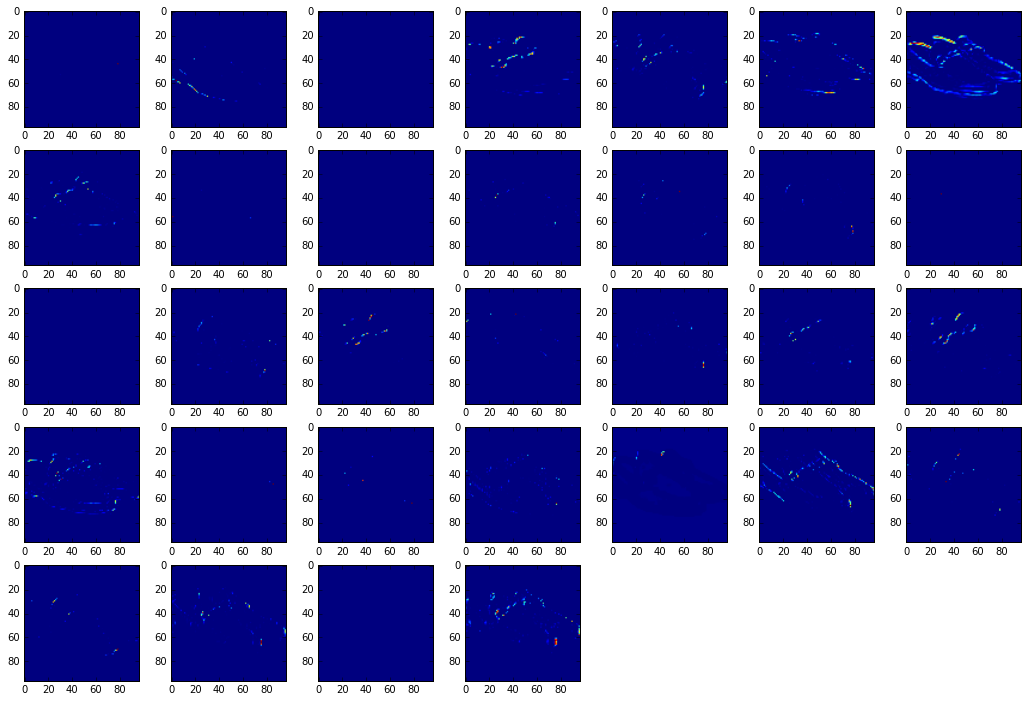

In [24]:
# Plot maxpooled image (after first convolution, maxpooling and seconf convolution) for each filter

fig = plt.figure(figsize=(18, 12))
for x in range(1,33):
    temp_image = np.squeeze(conv2_image[0][:,:,:,x-1])
    fig.add_subplot(5,7,x)
    plt.imshow(temp_image)
plt.show()